In [1]:
import warnings
warnings.filterwarnings('ignore')

# Fertility Rate Prediction Model 

>By Tom Grigg and Erika Russi (DS-10.22.2018)

Total Fertility Rate (TFR) is defined as the "average number of children that would be born to a woman by the time
she ended childbearing if she were to pass through all her childbearing years conforming to the age-specific fertility
rates of a given year." TFR is the best single measure to compare fertility across populations. 

We built a model that predicts the TFR (births per woman) of a country in a given year. The independent variables in our model consisted of the following predictors by country and year (unless specified otherwise, all data pulled from the World Bank DataBank):
* GDP per capita (current US$)
* Population Density (people per sq. km of land area)
* Life expectancy at birth, total (years)
* Population ages 0-14 (% of total)
* Population ages 15-64 (% of total)
* Population ages 65 and above (% of total)
* Mortality rate, under-5 (per 1,000 live births)
* Mortality rate, infant (per 1,000 live births); and

From the Geert Hofstede model for Cultural Dimensions (kept constant for each country across time):
* Long Term Orientation	Index (measured 0 - 100 for each country)
* Indulgence vs. Restraint Index (measured 0 - 100 for each country)

# Preparing Data

Our data comes from two main sources: World Bank DataBank and the Geert Hofstede model for Cultural Dimensions. These two sources store elements of data that we are interested in in different ways, and excess data that needs to be trimmed and cleaned. We defined a data massaging class called Masseuse to handle this step.

### Masseuse class

The masseuse object reads in the necessary CSV files from the specified path and begins merging into the main dataframe. Data in the World Bank datasets holds feature-values for each year in columns, but we wanted this data to be indexable by country and year. We elected to reframe our data with a MultiIndex of the form (ISO-3 Country Code, Year) so that the geography was unambiguous. This involved filtering the data for overlapping regions to avoid recounting further into our analysis. 


We first import the masseuse class and tell it to construct our data.

In [2]:
from masseuse import Masseuse

m = Masseuse(csv_dir='/Users/griggles/Documents/FLATIRON/PROJECT_2/csv/')
data = m.build_data()

We then build dummy variables for our categorical data. We only had one category which was datapoints continental region. We drop one of oue dummy variables from the data in order to remove initial multicollinearity. We also found multicollinearity caused by percentage of people between 15 and 64, so we dropped this too (more on this later).

In [3]:
import pandas as pd

df = pd.get_dummies(data, columns=['continent'], drop_first=True)
df = df.drop(columns=['pop_percentage_15_to_64'])

# Regression


### Feature Engineering

#### Log Density

The population density data we pulled was very spread out. For instance,  in 2017 Macao has nearly 21,000 people per sq. km., while Mongolia has only 2 people per sq. km. We researched other studies on population density and realized that the convention for its analysis was to take the log of the population density. When doing this, we wouldn't need to correct for outliers like Macao because the spread of the data was reduced.

In [4]:
import numpy as np
import seaborn as sns


df['log_density'] = np.log(df['density'])

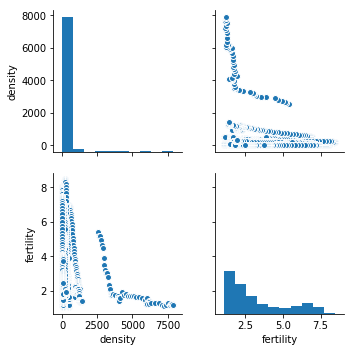

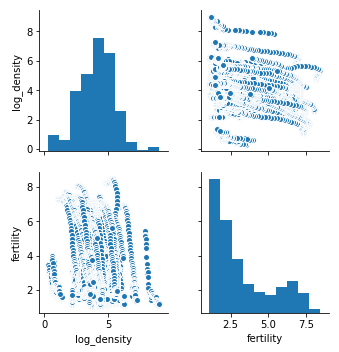

In [5]:
sns.pairplot(df, vars=['density', 'fertility'])
sns.pairplot(df, vars=['log_density', 'fertility'])

In [6]:
from matplotlib import pyplot as plt
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn import metrics

features = df.iloc[:,1:]
target = df['fertility']
features.head()

mort_rate_under_5  pop_percentage_above_65  \
Country Code Years                                               
ALB          1984                58.2                 5.390937   
             1985                54.0                 5.399862   
             1986                50.4                 5.413536   
             1987                47.2                 5.417392   
             1988                44.5                 5.423440   

                    mort_rate_infant  pop_percentage_under_14  \
Country Code Years                                              
ALB          1984               48.9                34.310923   
             1985               45.7                33.987349   
             1986               42.9                33.709853   
             1987               40.5                33.476210   
             1988               38.3                33.263863   

                    life_expectancy     density         gdp  \
Country Code Years                                            
ALB          1984            71.134  106.001058  662.520052   
             1985            71.388  108.202993  662.914793   
             1986            71.605  110.315146  719.157296   
             1987            71.760  112.540328  699.384292   
             1988            71.843  114.683796  676.566733   

                    long term orientation  indulgence vs restraint  \
Country Code Years                                                   
ALB          1984                    61.0                     15.0   
             1985                    61.0                     15.0   
             1986                    61.0                     15.0   
             1987                    61.0                     15.0   
             1988                    61.0                     15.0   

                    continent_Americas  continent_Asia  continent_Europe  \
Country Code Years                                                         
ALB          1984                    0               0                 1   
             1985                    0               0                 1   
             1986                    0               0                 1   
             1987                    0               0                 1   
             1988                    0               0                 1   

                    continent_Oceania  log_density  
Country Code Years                                  
ALB          1984                   0     4.663449  
             1985                   0     4.684009  
             1986                   0     4.703341  
             1987                   0     4.723312  
             1988                   0     4.742179

#### Scaling 

Initially we scaled our variables in order to standardise their variance. After a few iterations of our model we noticed that our p-values were being negatively affected by this standardisation (particularly due to the presence of percentage-values in our data, i.e. pre-scaled). We decided not to standardise the data in our final OLS regression. 

### Model Selection

#### Polynomial Regression

Once we reviewed the scatterplot matrix illustrating how each variable interacted with each other, we noticed that some variables likely had a square relationship. For the preprocessing of our polynomial regression model, we generated interactive variables up to the exponential power of 2.


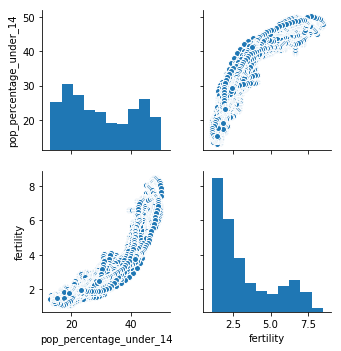

In [7]:
sns.pairplot(df, vars=['pop_percentage_under_14', 'fertility'])

In [8]:
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=32,test_size=0.2)


In [9]:
from sklearn import preprocessing
from sklearn import pipeline

poly = preprocessing.PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
features_135_train = pd.DataFrame(poly.fit_transform(X_train), index=X_train.index, columns=poly.get_feature_names(X_train.columns))
features_135_test = pd.DataFrame(poly.fit_transform(X_test), index=X_test.index, columns=poly.get_feature_names(X_test.columns))

### Feature Selection

#### Variance

We begun by removing low variance variables from our regression analysis - due to the differing scales of our independent variables this required us to standardise our variable matrix so that variance could be compared. We removed all variables whose standardised variance fell below our threshold of 0.5.


In [10]:
from sklearn.feature_selection import VarianceThreshold

thresholder = VarianceThreshold(threshold=.5)

def variance_threshold_selector(data, threshold=0.5):
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

features_selected_train = variance_threshold_selector(features_135_train)

#### Correlation

After reviewing our correlation matrix (visualized as a heat map), we removed any variables with a collinearity above .95 (i.e. any predictors that were highly correlated with each other). Doing so also assisted us with reducing collinearity which could make our estimates very sensitive to slight changes in our model.

#### Multi-collinearity

After doing initial runs of our model, we noticed that the parameter 'Population ages 15-64 (% of total)' was tainting the probability value of other variables with which it was interacting. We surmised that this population metric was highly correlated with the other two percentage-based population metrics, so we ultimately removed it from the analysis. Once we did so, the p-values were below the .05 threshold for a 95% confidence level.


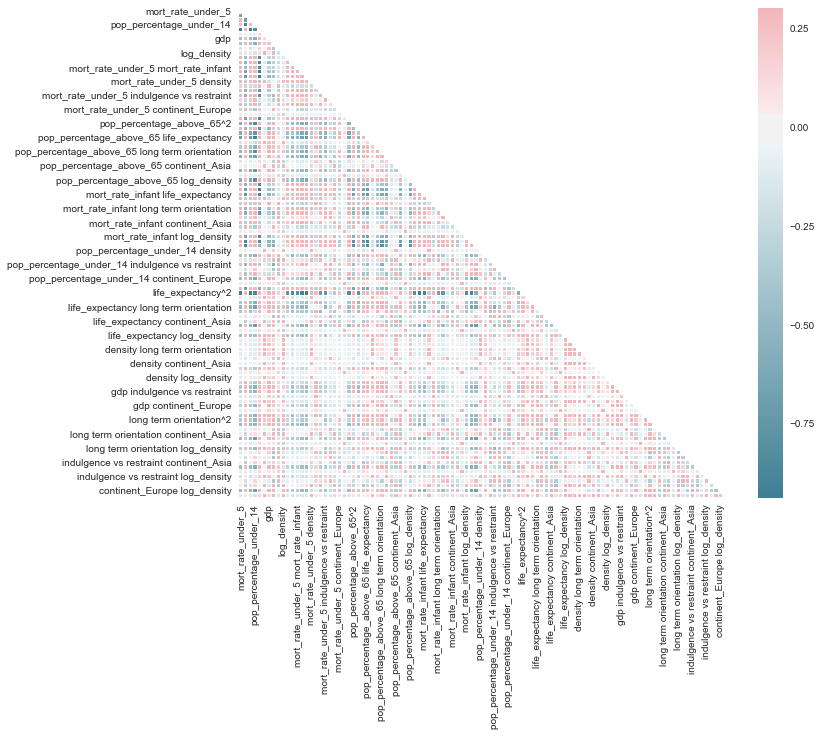

In [11]:
import seaborn as sns

sns.set(style="white")


# Compute the correlation matrix
corr = features_selected_train.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": 1})

In [12]:
def calculate_cols_to_drop(upper):
    #to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
    shape = upper.shape
    print(shape)
    row_index = upper.index
    col_index = upper.columns
    to_drop = []
    
    for row in range(0, shape[0]):
        for col in range(0, shape[1]):
            #print(upper.iloc[row,col])
            if upper.iloc[row, col] > 0.95:
                if row_index[row] in to_drop or col_index[col] in to_drop:
                    pass
                else:
                    to_drop.append(col_index[col])
    return to_drop

In [13]:
# Create correlation matrix
corr_matrix = features_selected_train.corr().abs()

# Select upper triangle of correlation matrix (so as not to include self-correlations of 1)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

features_selected_train.drop(columns=to_drop, inplace=True)

### Training Iterations

#### First Attempt

In [14]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression, mutual_info_regression

def information_selector(X, y, scoring, k=5):
    selector = SelectKBest(score_func=scoring, k=k)
    selector.fit(X, y)
    return X[X.columns[selector.get_support(indices=True)]]

test = SelectKBest(score_func=mutual_info_regression, k=30)
fit = test.fit(features_selected_train, y_train)

features_selected_train = information_selector(features_selected_train, y_train, mutual_info_regression, k=30)



In [15]:
lm = linear_model.LinearRegression(fit_intercept=True)
model = lm.fit(features_selected_train, y_train)

import statsmodels.api as sm
import pylab
import statsmodels.formula.api as smf

est = sm.OLS(y_train, features_selected_train)
est2 = est.fit()
hi_p = est2.pvalues
p_limit = 0.05
hi_p = hi_p[hi_p > p_limit]
print(hi_p.index.tolist())

['long term orientation', 'mort_rate_under_5^2', 'mort_rate_under_5 pop_percentage_above_65', 'mort_rate_under_5 density', 'mort_rate_under_5 long term orientation', 'mort_rate_under_5 indulgence vs restraint', 'pop_percentage_under_14 continent_Europe', 'long term orientation indulgence vs restraint']


#### Rejecting Null Hypotheses: Dropping High P-Vals to improve model

In [16]:
#RETRAIN WITH DROPPED HIGH P_VALUES
features_selected_train = features_selected_train.drop(columns=hi_p.index.tolist())

## Final Model 

Absolute Error:  0.30255669762836795
Squared Error:  0.1742911858907531
Root Squared Error:  0.4174819587607985


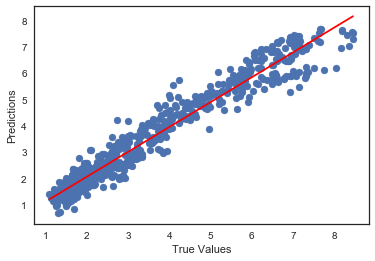

In [17]:
#NEW MODEL

test = SelectKBest(score_func=mutual_info_regression, k='all')
fit = test.fit(features_selected_train, y_train)

features_selected_train = information_selector(features_selected_train, y_train, mutual_info_regression, k='all')

# fit a model
lm2 = linear_model.LinearRegression(fit_intercept=True)
model2 = lm2.fit(features_selected_train, y_train)

features_selected_test = features_135_test[features_selected_train.columns]
y_pred = lm2.predict(features_selected_test)

print('Absolute Error: ', metrics.mean_absolute_error(y_test, y_pred))
print('Squared Error: ', metrics.mean_squared_error(y_test, y_pred))
print('Root Squared Error: ', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

from matplotlib import pyplot as plt

plt.scatter(y_test, y_pred)

plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, y_pred, 1))(np.unique(y_test)), color='r')


In [18]:
est3 = sm.OLS(y_train, features_selected_train)
est4 = est3.fit()
print(est4.summary())

                            OLS Regression Results                            
Dep. Variable:              fertility   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                 1.197e+04
Date:                Fri, 07 Dec 2018   Prob (F-statistic):               0.00
Time:                        14:33:47   Log-Likelihood:                -1613.9
No. Observations:                3136   AIC:                             3272.
Df Residuals:                    3114   BIC:                             3405.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

In [19]:
import plotly.plotly as py
import plotly.graph_objs as go

plot = [go.Bar(
            x=est4.params.index,
            y=est4.params.values
    )]

py.iplot(plot)